In [378]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import numpy as np
from matplotlib.patches import FancyArrowPatch, Patch, Rectangle
from mpl_toolkits.mplot3d import proj3d
from matplotlib.lines import Line2D
from sofia_redux.toolkit.resampling.resample_utils import (
    coordinate_covariance, distribution_variances)
from sofia_redux.toolkit.resampling.resample import Resample
from skimage import data as image_data
from astropy.stats import gaussian_fwhm_to_sigma
import numpy as np
from sofia_redux.toolkit.resampling.resample import Resample
from sofia_redux.toolkit.resampling.resample_utils import relative_density
from sofia_redux.toolkit.resampling.resample_utils import shaped_adaptive_weight_matrices
from sofia_redux.toolkit.resampling.resample_utils import scaled_adaptive_weight_matrices
from sofia_redux.toolkit.resampling.resample_utils import distribution_variances
import matplotlib.pyplot as plt


%matplotlib inline

2-D Example

Error: 0.006229326422933866


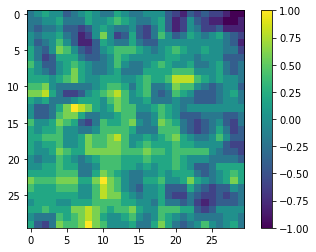

In [336]:
image = image_data.camera()
image = image.astype(float)
image = image[232:360, 242:370]
image -= image.min()
image /= image.max()

blank = image[:30, 90:120]
error = np.median(np.abs(blank - np.median(blank))) / 0.6745

print('Error:', error)
plt.imshow((((blank - np.nanmin(blank)) / (np.nanmax(blank) - np.nanmin(blank))) - 0.5) * 2)
plt.colorbar()

fwhm = 1
sigma = fwhm * gaussian_fwhm_to_sigma
alpha = 2 * sigma ** 2
order = 3
window = 12

y, x = np.mgrid[:image.shape[0], :image.shape[1]]
coordinates = np.stack([c.ravel() for c in [x, y]])
r = Resample(coordinates, image.ravel(), error=error, order=order, window=window)

xout = np.linspace(0, image.shape[1], image.shape[1] * 5)
yout = np.linspace(0, image.shape[0], image.shape[0] * 5)



In [337]:
fit, err, counts, weight, distance_weights, rchi2 = r(
    xout, yout, smoothing=alpha,
    get_error=True, get_counts=True, get_weights=True,
    get_distance_weights=True, get_rchi2=True, get_cross_derivatives=False,
    get_offset_variance=False, jobs=-1)

In [338]:
fit_sc, err_sc, weight_sc, distance_weights_sc, rchi2_sc = r(
    xout, yout, smoothing=sigma,
    get_error=True, get_counts=False, get_weights=True,
    get_distance_weights=True, get_rchi2=True, get_cross_derivatives=False,
    get_offset_variance=False, jobs=-1,
    adaptive_threshold=1.0, adaptive_algorithm='scaled', edge_threshold=1, order_algorithm='extrapolate')


In [339]:
fit_sh, err_sh, weight_sh, distance_weights_sh, rchi2_sh = r(
    xout, yout, smoothing=sigma,
    get_error=True, get_counts=False, get_weights=True,
    get_distance_weights=True, get_rchi2=True, get_cross_derivatives=False,
    get_offset_variance=False, jobs=-1,
    adaptive_threshold=1.0, adaptive_algorithm='shaped', order_algorithm='extrapolate')

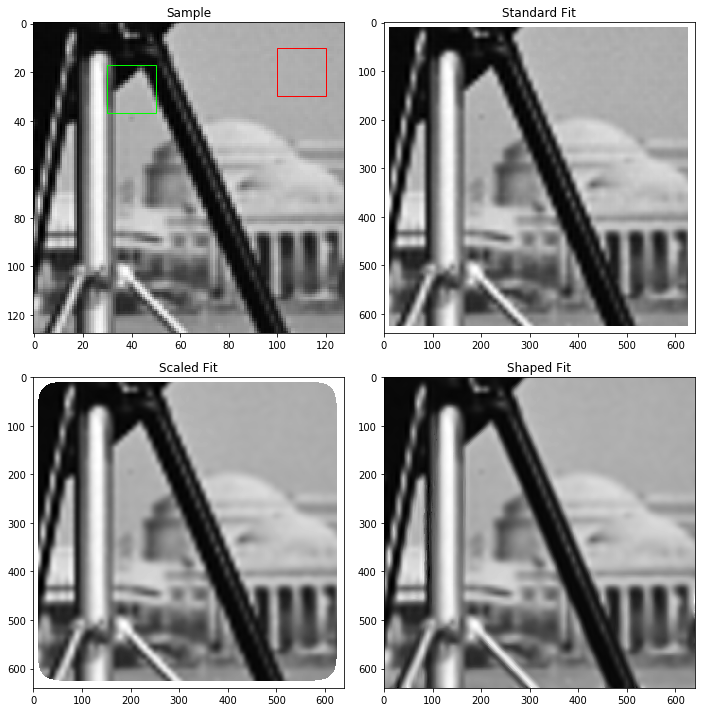

In [394]:
fig, ax = plt.subplots(2, 2, tight_layout=True, figsize=(10, 10))
ax[0, 0].imshow(image, cmap='binary_r') #, vmin=0, vmax=1)
ax[0, 1].imshow(fit, cmap='binary_r', vmin=0, vmax=1)
ax[1, 0].imshow(fit_sc, cmap='binary_r', vmin=0, vmax=1)
ax[1, 1].imshow(fit_sh, cmap='binary_r', vmin=0, vmax=1)
# for a in ax.ravel()[2:]:
#     a.set_xticks([])
#     a.set_yticks([])
    
ax[0, 0].set_title("Sample", fontsize=12)
ax[1, 0].set_title("Scaled Fit", fontsize=12)
ax[0, 1].set_title("Standard Fit", fontsize=12)
ax[1, 1].set_title("Shaped Fit", fontsize=12)

x0, x1 = 30, 50
y0, y1 = 17, 37
rect = Rectangle((x0, y0), x1 - x0, y1 - y0, color='lime', fill=False)
ax[0, 0].add_patch(rect)

sx0, sx1 = 100, 120
sy0, sy1 = 10, 30
rects = Rectangle((sx0, sy0), sx1 - sx0, sy1 - sy0, color='red', fill=False)
ax[0, 0].add_patch(rects)

plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/camera_fits.png',
            bbox_inches='tight', pad_inches=0.1)
plt.show()

-2.25 2.25
452.0
0.0007479190295357127
1.5786072968239515
1.2362585827687267
0.0007029195184496042
1.5442462806013568
1.06082087220044


/Users/dperera/opt/anaconda3/envs/dev2/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/Users/dperera/opt/anaconda3/envs/dev2/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


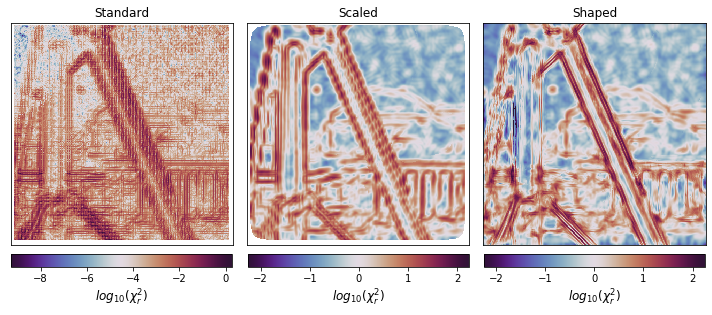

In [341]:
fig, ax = plt.subplots(1, 3, tight_layout=True, figsize=(10, 6))
all_chi = rchi = np.stack([rchi2, rchi2_sh, rchi2_sc]).ravel()
vmin = np.log10(np.nanmin(all_chi))
vmax = np.log10(np.nanmax(all_chi))
vmax = 2.25
vmin = -vmax
#color = 'gray'
#color = 'Spectral_r'
#color = 'seismic'
color = 'twilight_shifted'
im0 = ax[0].imshow(np.log10(rchi2), cmap=color)
im1 = ax[1].imshow(np.log10(rchi2_sc), cmap=color, vmin=vmin, vmax=vmax)
im2 = ax[2].imshow(np.log10(rchi2_sh), cmap=color, vmin=vmin, vmax=vmax)

for a in ax:
    a.set_xticks([])
    a.set_yticks([])
    
ax[0].set_title('Standard', fontsize=12)
ax[1].set_title('Scaled', fontsize=12)
ax[2].set_title('Shaped', fontsize=12)
    
cbar_ax_w = fig.add_axes([0.02, 0.193, 0.307, 0.03])
cb = fig.colorbar(im0, cax=cbar_ax_w, orientation='horizontal')
cb.set_label(label=r'${log}_{10}(\chi_r^2)$', fontsize=12)

cbar_ax_w = fig.add_axes([0.35, 0.193, 0.307, 0.03])
cb = fig.colorbar(im1, cax=cbar_ax_w, orientation='horizontal')
cb.set_label(label=r'${log}_{10}(\chi_r^2)$', fontsize=12)

cbar_ax_w = fig.add_axes([0.677, 0.193, 0.307, 0.03])
cb = fig.colorbar(im2, cax=cbar_ax_w, orientation='horizontal')
cb.set_label(label=r'${log}_{10}(\chi_r^2)$', fontsize=12)

print(vmin, vmax)
print(np.median(counts))
print(np.exp(np.nanmean(np.log(rchi2))))
print(np.exp(np.nanmean(np.log(rchi2_sc))))
print(np.exp(np.nanmean(np.log(rchi2_sh))))

print(np.nanmedian(rchi2))
print(np.nanmedian(rchi2_sc))
print(np.nanmedian(rchi2_sh))

# plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/camera_fits.png',
#             bbox_inches='tight', pad_inches=0.1)
plt.show()

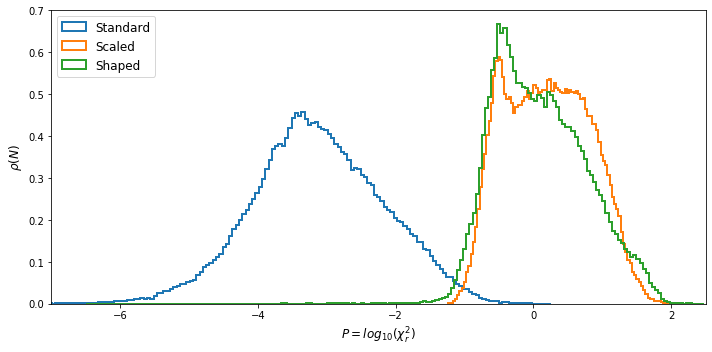

standard -3.126145416746862 0.9047619334146307
scaled 0.1982741059209199 0.3714843435274902
shaped 0.0921093197204297 0.4423648248536175


In [465]:
import warnings
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(10, 5))

weights = np.full(rchi2.size, 1 / rchi2.size)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    ax.hist(np.log10(rchi2.ravel()), log=False, bins=200, histtype='step', density=True, label='Standard',
            lw=2, stacked=True)
    ax.hist(np.log10(rchi2_sc.ravel()), log=False, bins=100, histtype='step', density=True, label='Scaled',
            lw=2, stacked=True)
    ax.hist(np.log10(rchi2_sh.ravel()), log=False, bins=200, histtype='step', density=True, label='Shaped',
            lw=2, stacked=True)
    
ax.legend(loc='upper left', fontsize=12)
plt.xlim(-7, 2.5)
# plt.ylim(1e-4, 1)
plt.xlabel(r"$P = {log}_{10}(\chi_r^2)$", fontsize=12)
plt.ylabel(r"$\rho(N)$", fontsize=12)
plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/camera_chi2.png',
            bbox_inches='tight', pad_inches=0.1)
plt.show()

from scipy.stats import norm

r10 = np.log10(rchi2.ravel())
r10 = r10[np.isfinite(r10)]
mean, std = norm.fit(r10)
print('standard', mean, std ** 2)

r10_sc = np.log10(rchi2_sc.ravel())
r10_sc = r10_sc[np.isfinite(r10_sc)]
mean_sc, std_sc = norm.fit(r10_sc)
print('scaled', mean_sc, std_sc ** 2)

r10_sh = np.log10(rchi2_sh.ravel())
r10_sh = r10_sh[np.isfinite(r10_sh)]
mean_sh, std_sh = norm.fit(r10_sh)
print('shaped', mean_sh, std_sh ** 2)




/Users/dperera/opt/anaconda3/envs/dev2/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


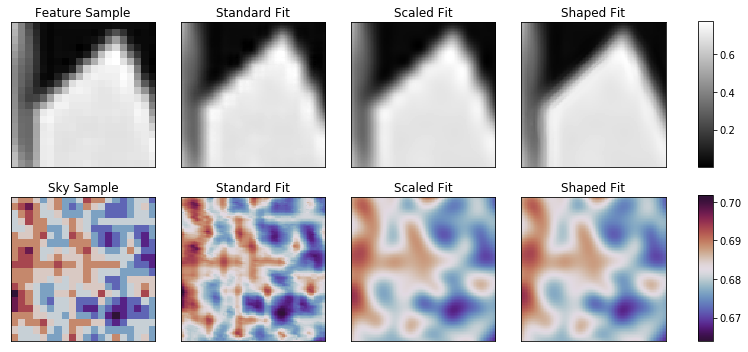

In [429]:
fig, ax = plt.subplots(2, 4, tight_layout=True, figsize=(10, 5))
vmin = np.nanmin(image[y0:y1, x0:x1])
vmax = np.nanmax(image[y0:y1, x0:x1])
color = 'binary_r'
feature = ax[0, 0].imshow(image[y0:y1, x0:x1], cmap=color)
ax[0, 1].imshow(fit[y0*5:y1*5, x0*5:x1*5], cmap=color, vmin=vmin, vmax=vmax)
ax[0, 2].imshow(fit_sc[y0*5:y1*5, x0*5:x1*5], cmap=color, vmin=vmin, vmax=vmax)
ax[0, 3].imshow(fit_sh[y0*5:y1*5, x0*5:x1*5], cmap=color, vmin=vmin, vmax=vmax)

for a in ax.ravel():
    a.set_xticks([])
    a.set_yticks([])
    
ax[0, 0].set_title('Feature Sample')
ax[0, 1].set_title('Standard Fit')
ax[0, 2].set_title('Scaled Fit')
ax[0, 3].set_title('Shaped Fit')

smin = np.nanmin(image[sy0:sy1, sx0:sx1])
smax = np.nanmax(image[sy0:sy1, sx0:sx1])
color = 'twilight_shifted'
sky = ax[1, 0].imshow(image[sy0:sy1, sx0:sx1], cmap=color)
ax[1, 1].imshow(fit[sy0*5:sy1*5, sx0*5:sx1*5], cmap=color, vmin=smin, vmax=smax)
ax[1, 2].imshow(fit_sc[sy0*5:sy1*5, sx0*5:sx1*5], cmap=color, vmin=smin, vmax=smax)
ax[1, 3].imshow(fit_sh[sy0*5:sy1*5, sx0*5:sx1*5], cmap=color, vmin=smin, vmax=smax)

for a in ax.ravel():
    a.set_xticks([])
    a.set_yticks([])
    
ax[1, 0].set_title('Sky Sample')
ax[1, 1].set_title('Standard Fit')
ax[1, 2].set_title('Scaled Fit')
ax[1, 3].set_title('Shaped Fit')

cbar_ax_f = fig.add_axes([1, 0.525, 0.02, 0.405])
cb_feature = fig.colorbar(feature, cax=cbar_ax_f)
cb.set_label(label=r'Value', fontsize=12)

cbar_ax_s = fig.add_axes([1, 0.04, 0.02, 0.405])
cb_feature = fig.colorbar(sky, cax=cbar_ax_s)
cb.set_label(label=r'${log}_{10}(\chi_r^2)$', fontsize=12)


plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/camera_samples.png',
            bbox_inches='tight', pad_inches=0)
plt.show()


In [359]:
90*5

450